<a href="https://colab.research.google.com/github/ResponsiveWebApps/Categorize_Flowers/blob/master/Categorize_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing packages


In [1]:
import os
import numpy as np
import glob
import shutil

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Downloading dataset

In [2]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228818944/228813984 [==============================] - 2s 0us/step


Creating 5 categories for flowers

In [3]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


Directories for training sets

In [4]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

Batch size and image shape

In [5]:
batch_size = 100
IMG_SHAPE =  100

Image augmentation

Found 2935 images belonging to 5 classes.


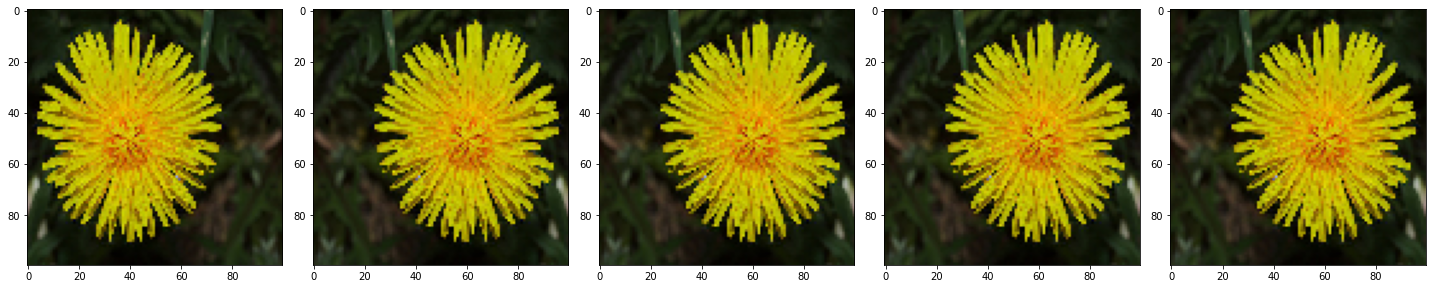

Found 2935 images belonging to 5 classes.
Found 2935 images belonging to 5 classes.
Found 2935 images belonging to 5 classes.
Found 2935 images belonging to 5 classes.


In [6]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Image rotation
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

# Image zoom

image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

# All image augmentation together

image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='sparse')

CNN Model

In [7]:
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(5))
# Compile model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train model

In [10]:
epochs = 100

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
)

Epoch 1/100
30/30 [==============================] - 27s 908ms/step - loss: 0.3592 - accuracy: 0.8664 - val_loss: 0.3179 - val_accuracy: 0.8862
Epoch 2/100
30/30 [==============================] - 27s 890ms/step - loss: 0.3636 - accuracy: 0.8586 - val_loss: 0.2981 - val_accuracy: 0.8859
Epoch 3/100
30/30 [==============================] - 26s 881ms/step - loss: 0.3316 - accuracy: 0.8685 - val_loss: 0.2979 - val_accuracy: 0.8978
Epoch 4/100
30/30 [==============================] - 26s 856ms/step - loss: 0.3537 - accuracy: 0.8685 - val_loss: 0.2925 - val_accuracy: 0.8940
Epoch 5/100
30/30 [==============================] - 25s 845ms/step - loss: 0.3275 - accuracy: 0.8807 - val_loss: 0.2836 - val_accuracy: 0.8896
Epoch 6/100
30/30 [==============================] - 26s 856ms/step - loss: 0.3452 - accuracy: 0.8698 - val_loss: 0.2768 - val_accuracy: 0.8893
Epoch 7/100
30/30 [==============================] - 26s 861ms/step - loss: 0.3233 - accuracy: 0.8804 - val_loss: 0.2624 - val_accuracy:

Training and validation graphs

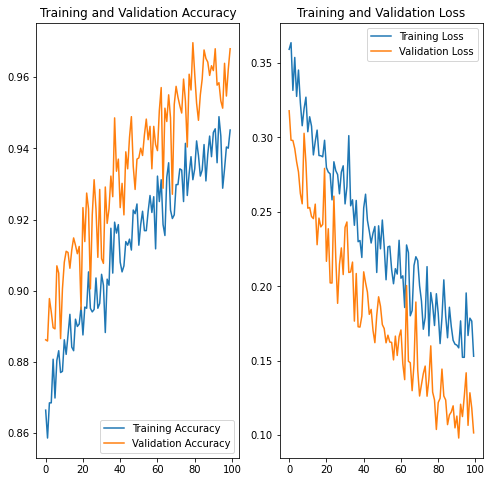

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()